In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets
import DRLPDE.create as create

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

In [2]:
loadmodel = 'Thesisexample2'

In [3]:
with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

param = importlib.import_module(".Thesisexample2", package='examples')

input_dim = [param.x_dim, param.t_dim, param.hyper_dim]
input_range = param.boundingbox + param.t_range + param.hyper_range
output_dim = param.output_dim

problem_parameters = {'input_dim': [param.x_dim, param.t_dim, param.hyper_dim],
                    'output_dim': param.output_dim,
                    'input_range': param.boundingbox + param.t_range + param.hyper_range,
                    'Boundaries': [param.boundingbox,
                                    param.list_of_walls, 
                                    param.solid_walls, 
                                    param.inlet_outlet, 
                                    param.list_of_periodic_ends, 
                                    param.mesh]}

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
    MyNeuralNetwork = neuralnets.ResNetNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
[ [xmin, xmax], [ymin, ymax]] =  param.boundingbox

dim_space = 2
dim_full = dim_space + 1

mu = 1.0
L = 1.0  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 4.0
maxT = 3.0 # Max time

numpts_r = 20
numpts_th =  120
numpts_time = 100
dtime = maxT/numpts_time

r,th,t_var = torch.meshgrid([torch.linspace(0,1, numpts_r), \
                         torch.linspace(0,2*math.pi, numpts_th), \
                         torch.linspace(0,maxT, numpts_time+1)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), t_var.reshape(-1)], dim=-1)

############# Plot, Video, Error ##################################

r_plot, th_plot = torch.meshgrid([torch.linspace(0,1, numpts_r),
                                 torch.linspace(0,2*math.pi, numpts_th)])

x1plot = r_plot*torch.cos(th_plot)
x2plot = r_plot*torch.sin(th_plot)

xplot = torch.stack( [x1plot.reshape(-1), x2plot.reshape(-1), torch.zeros((numpts_r*numpts_th))], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*maxT*r_plot/(numpts_r-1)/(numpts_th-1)/(numpts_time-1)
integral_factor = integral_factor.numpy()

x1plot = x1plot.numpy()
x2plot = x2plot.numpy()

c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
flow_levels = np.linspace(-6.0, 6.0, 101)
flow_ticks = np.linspace(-6.0, 6.0, 5)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


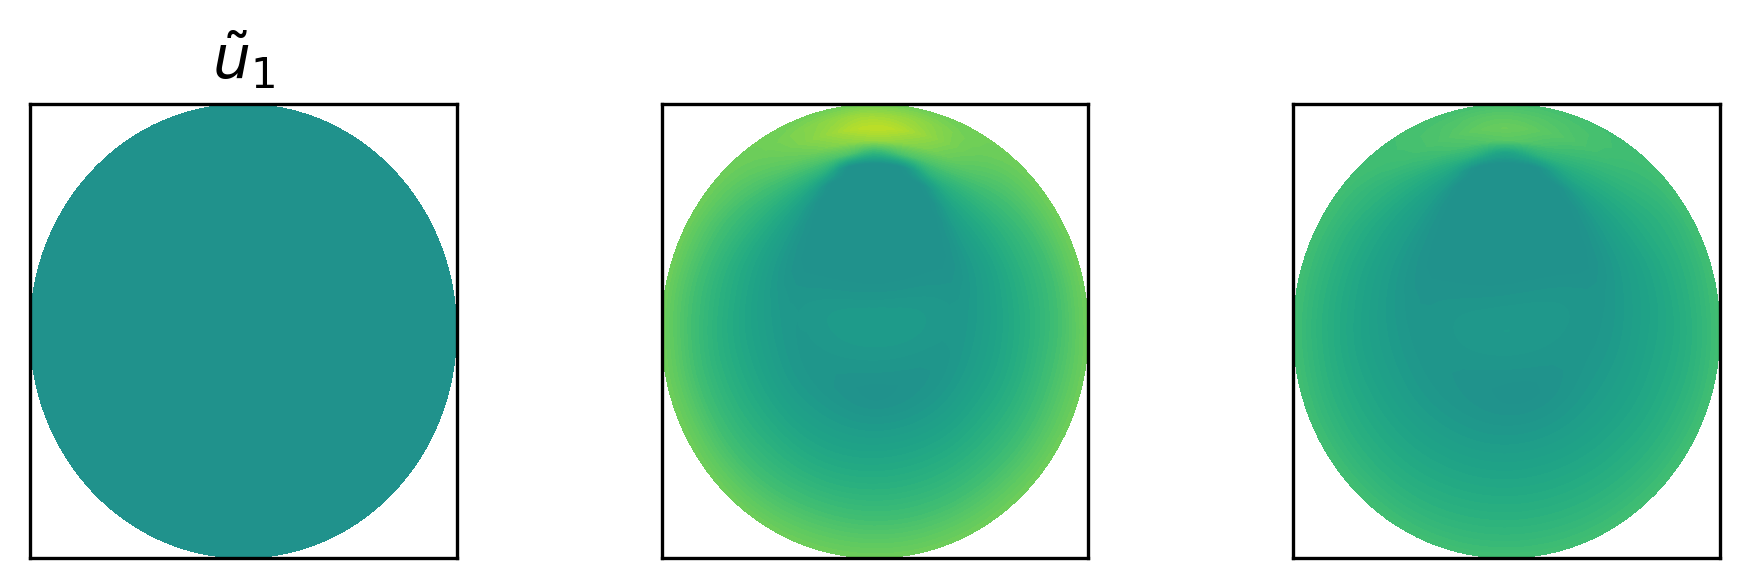

In [6]:
xplot.requires_grad = False
xplot[:,2] = 0.0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_0 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)

xplot.requires_grad = False
xplot[:,2] = 1.0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_1 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)

xplot.requires_grad = False
xplot[:,2] = 2.5
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_2 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)
#############################################################################

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[6.4, 2.0])
plt.tight_layout(pad=0.5)

## Plot 0

contour0 = ax[0].contourf(x1plot, x2plot, Trained_Vel_0, 
                            levels=flow_levels, cmap=plt.cm.viridis)
                            
ax[0].set_title(r'$\tilde{u}_1$')

ax[0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour3 = ax[1].contourf(x1plot, x2plot, Trained_Vel_1, 
                            levels=flow_levels, cmap=plt.cm.viridis)
ax[1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour6 = ax[2].contourf(x1plot, x2plot, Trained_Vel_2, 
                            levels=flow_levels, cmap=plt.cm.viridis)
ax[2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


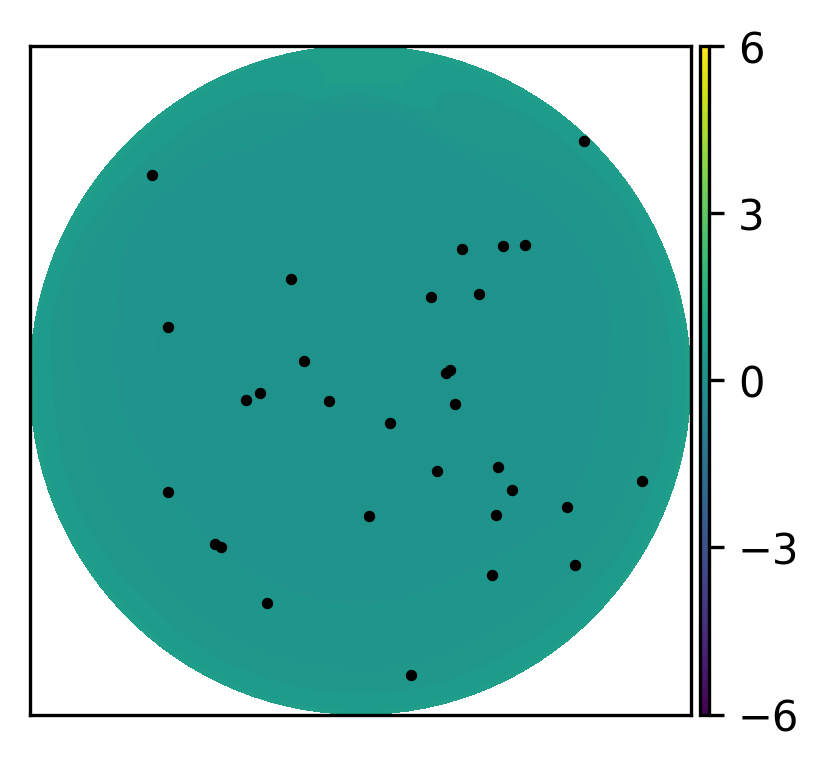

In [7]:
### Make video

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3.0, 2.8])
plt.tight_layout(pad=0.75)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar_param = fig.add_axes(
    [ax.get_position().x1 + 0.01,
     ax.get_position().y0,
     0.01,
     ax.get_position().height])

def RK4(x, h, u):
    ### Calculate x(t+1) from x' = u(x,t) using Runge-Kutta 4
    ### xt = (x,t)
    ### Used for plotting streamlines and making animations with tracer particles

    x0 = x

    k1 = u(x).detach()

    x.requires_grad = False
    x[:,:-1] = x0[:,:-1] + h*k1/2
    x[:,-1] = x0[:,-1] + h/2
    x.requires_grad = True

    k2 = u(x).detach()

    x.requires_grad = False
    x[:,:-1] = x0[:,:-1] + h*k2/2 
    x.requires_grad = True

    k3 = u(x).detach()

    x.requires_grad = False
    x[:,:-1] = x0[:,:-1] + h*k3
    x[:,-1] = x0[:,-1] + h
    x.requires_grad = True

    k4 = u(x).detach()
    
    x.requires_grad = False
    x[:,:-1] = x0[:,:-1] + h/6 * (k1 + k2 + k3 + k4)
    x[:,-1] = x0[:,-1] + h
    return x

domain = create.theDomain(problem_parameters)
RandPoints = create.InteriorPoints(50, domain, input_dim, input_range, 'cpu')
RandPoints.location[:,-1] = 0.0
outside = torch.zeros( RandPoints.location.size(0), dtype=torch.bool)

h = 0.01
path = 'C:/Users/Kevin/Documents/Github/DRLPDE/images/'

framerate = 30
numframes = int(maxT/h)

for ii in range(numframes):
    xplot.requires_grad = False
    xplot[:,2] = ii*h
    xplot.requires_grad = True

    Velocity = model(xplot).reshape([numpts_r, numpts_th, 2])

    ax.cla()
    contour = ax.contourf(x1plot,
                          x2plot,
                       torch.sqrt(Velocity[:,:,0]**2 + Velocity[:,:,1]**2).detach().numpy(),
                       flow_levels, cmap=plt.cm.viridis)
    
    colorbar = plt.colorbar(contour, ticks=flow_ticks, cax = colorbar_param)
    colorbar.ax.tick_params(labelsize=10)

    ### Move 
    RandPoints.location[~outside,:] = RK4(RandPoints.location[~outside,:].requires_grad_(True), h, model)
    
    # Check if outside
    for wall in domain.checkinside:
        outside += wall.distance(RandPoints.location) < 0

    scatter = ax.scatter(RandPoints.location[~outside,0].detach().numpy(),
                RandPoints.location[~outside,1].detach().numpy(),
                s=3, c='k')

    figname = 'thesisexample2_' + str(ii) + '.png'

    plt.savefig(path + figname)

In [10]:
img_array = []
for ii in range(numframes):
    figname = 'thesisexample2_' + str(ii) + '.png'
    img = cv2.imread(path + figname)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter(path + 'Thesisexample2.mov',cv2.VideoWriter_fourcc(*'DIVX'), framerate, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


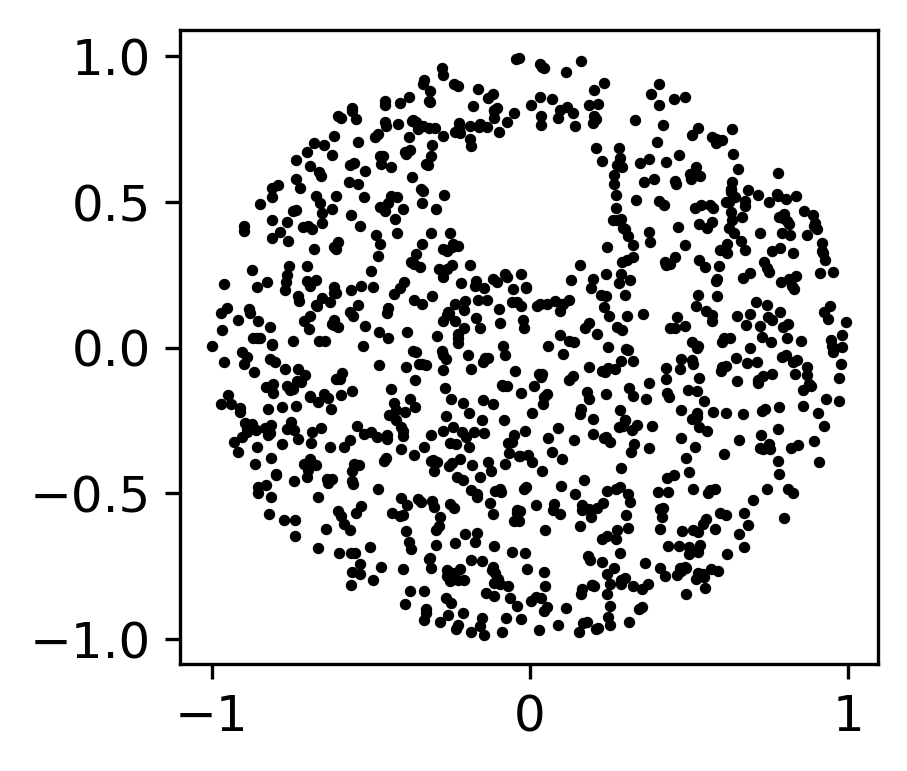

In [9]:
RandPoints = create.InteriorPoints(1000, domain, input_dim, input_range, 'cpu')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3.0, 2.8])
ax.scatter(RandPoints.location[:,0].detach().numpy(),
                RandPoints.location[:,1].detach().numpy(),
                s=3, c='k')